In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)

#contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
#ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order_leaves)[np.isin(ontological_order_leaves, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [5]:
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [69]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask

# def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures, model_ordering_leaf, model_region_surface, source_ordering, target_ordering, eval_cres):
    
#     nsource = len(source_ordering)
#     #n#target = len(target_ordering)
#     ncre = len(eval_cres)

#     ipsi_target_regions = connectivity_data.ipsi_target_regions
#     contra_target_regions = connectivity_data.contra_target_regions                               
#     ipsi_indices= np.asarray([])
#     contra_indices = np.asarray([])
#     for iy in target_ordering: 
#         ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#         contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
#     ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
#     contra_indices = np.asarray(contra_indices, dtype = int)    
#     reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
#     ntarget = len(reorder)
      
#     connectivity = np.zeros((ncre, nsource, ntarget))
#     connectivity[:] = np.nan
#     #structure_major_dictionary = connectivity_data.structure_major_dictionary
#     for c in range(ncre):
#         for i in range(nsource):
#             print(i,source_ordering[i])
#             sid = model_ordering_leaf[i,0]#structure_major_dictionary[source_ordering[i]]
#             gamma = surfaces[sid].gamma#gamma_dict[sid]
#             connectivity[c,i] = get_region_prediction3(cache,
#                                                       connectivity_data.structure_datas[sid],
#                                                       exp_structures = structures[sid],
#                                                       model_region_leaf = model_ordering_leaf[i,1],
#                                                        model_region_surface = model_region_surface[i,1],
#                                                       prediction_region= source_ordering[i],
#                                                       cre = eval_cres[c],
#                                                       gamma = surfaces[sid].bestgamma,
#                                                       surface = surfaces[sid],
#                                                       cre_model = True)
                                                      
#     connectivity = connectivity[:,:,reorder]                                                  
                                                      
#     return(connectivity)

# def get_region_prediction3(cache, structure_data,  exp_structures, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    
#     #model_experiments = np.where(exp_structures == model_region)[0]
#     model_experiments_leaf = np.where(exp_structures == model_region_leaf)[0]
#     nexp = len(model_experiments_leaf)
    
#     cres = structure_data.crelines[model_experiments_leaf]
#     mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

# #     if surface != None and cre_model != True:
# #         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
# #         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
# #         predictions = get_nw_predictions(projections, losses, gamma)
# #         output = np.mean(predictions, axis = 0)
        
#     if surface != None and cre_model == True:
#         projections = structure_data.reg_proj_norm[model_experiments_leaf]
#         centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
#         means = get_means(projections, cres, np.repeat(model_region_surface,nexp))
#         #print(means)
#         print(prediction_region)
#         #print(prediction_region, model_region,means.keys())
#         #supposed to check if theres a cre in that region
#         if np.isin(model_region_surface, list(means.keys())):
#             if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
#                 losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region_surface])
#                 predictions = get_nw_predictions(projections, losses, gamma)
#                 output = np.mean(predictions, axis = 0)
#             else:
#                 output = np.zeros(projections.shape[1])
#                 output[:] = np.nan
#         else:
#             output = np.zeros(projections.shape[1])
#             output[:] = np.nan           
# #     if surface == None and cre_model != True:
# #         means = get_means(projections, cres, [model_region])
# #         predictions = means[cres]
# #         output = np.mean(predictions, axis = 0)
        
#     if surface == None and cre_model == True:
        
        
#         modelcre_experiments = np.where(cres == cre)[0]
#         if len(modelcre_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
#             centroids = structure_data.centroids[model_experiments][modelcre_experiments]
#             #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
            
#     if surface == None and cre_model == False:
        
#         if len(model_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments]
#             centroids = structure_data.centroids[model_experiments]
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
        
#     return(output)


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


In [15]:
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [17]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000

# for m in range(len(list(connectivity_data.structure_datas.keys()))):
#     sid = major_structure_ids[m]
#     connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
#                                                                                  connectivity_data.structure_datas[sid].centroids,
#                                                                                  connectivity_data.creline[sid],connectivity_data.leafs[sid],
#                                                                                  frac_learn[m],
#                                                                                  gamma = gammas_surface[m])

In [ ]:
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 10000)
    
    



In [22]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [103]:
crelist = ['C57BL/6J']
eval_cres = ['C57BL/6J']
def get_aligned_ids(list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(ontological_order_leaves)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)
eval_cres = ['C57BL/6J']
ontological_order_leaves_majors = get_aligned_ids(ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(ontological_order_leaves,ontological_order)


# model_ordering_leaf = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
# model_ordering_summary = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_summaries = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()


In [ ]:
gs = gammas[[6,
        0,
        6,
        4,
        6,
        4,
        4,
        6,
        4,
        4,
        6,
        4]]

In [104]:
for m in range(12):
    sid = major_structure_ids[m]
    surfaces_str[sid].gamma = gs[m]
    #gamma_dict = gd_nw_leaf_creleaf2
    
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [139]:
connectivity_matrices = get_connectivity_matrices3(connectivity_data, 
                                                   surfaces = surfaces_str,
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering_leafs = model_ordering_leafs,
                                                   model_ordering_surfaces = model_ordering_summaries,
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves[117:123],#ontological_order_leaves,
                                                  target_ordering= ontological_order_leaves)

0 593.0
1 821.0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [106]:
target_ordering= ontological_order_leaves

rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions                               
ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)    
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
ntarget = len(reorder)

#cnames = np.concatenate([ipsi_colnames, contra_colnames])

In [107]:
colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])

In [108]:
connectivity_matrices_leafall = pd.DataFrame(connectivity_matrices[0], columns = cnames, index=np.asarray(['VISp1','VISp2/3','VISp4','VISp5','VISp6a','VISp6b']))

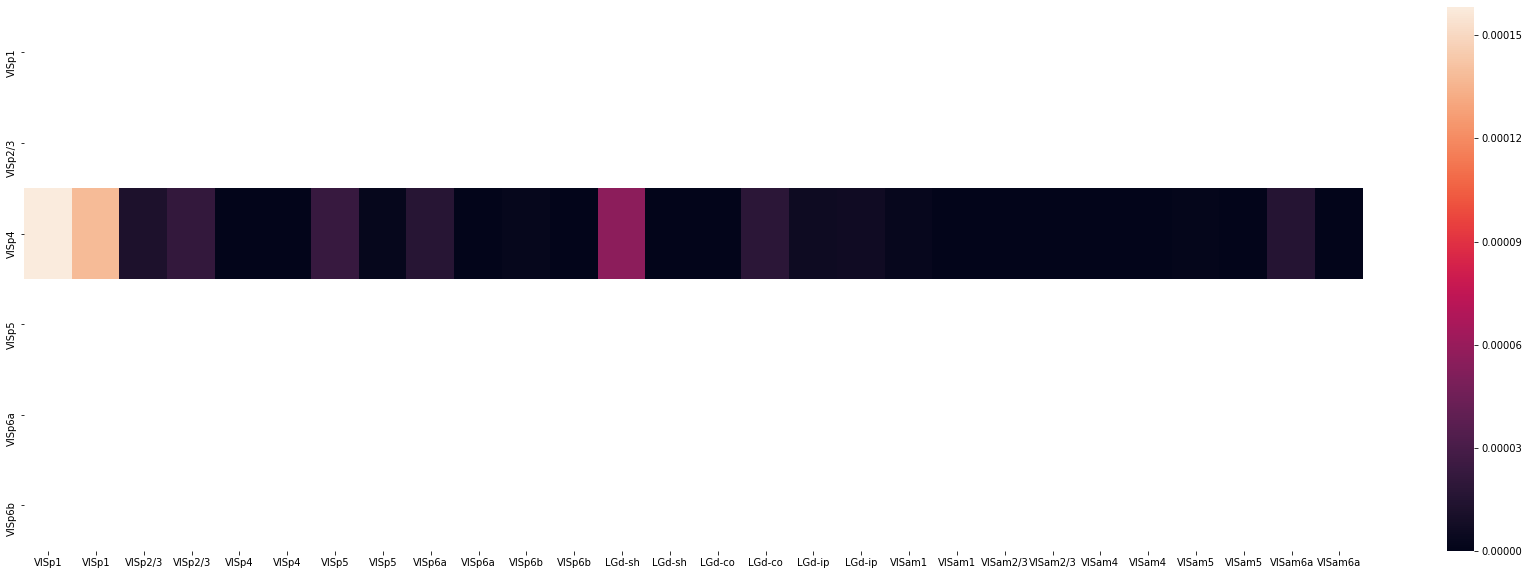

In [109]:
srs = np.asarray(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'])
trs = np.asarray(['VISp1', 'VISp2/3' ,'VISp4', 'VISp5' ,'VISp6a','VISp6b','LGd-sh', 'LGd-co', 'LGd-ip','VISam1','VISam2/3','VISam4','VISam5', 'VISam6a'])

fig, axes = plt.subplots(figsize = (30,10))
sns.heatmap(connectivity_matrices_leafall.loc[srs].loc[:,trs])

In [275]:

#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 
def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_surfaces, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = surfaces[sid].gamma#gamma_dict[sid]
            connectivity[c,i] = get_region_prediction3(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      #structures_sid = structures[sid],
                                                       structures_surface_sid =structures_surface[sid],
                                                       structures_smooth_sid= structures_smooth[sid],
                                                      model_region_leaf = model_ordering_leafs[i,1],
                                                       model_region_surface = model_ordering_surfaces[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    

    model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
    model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
    nexp_surface = len(model_experiments_surface)
    
    cres_surface = structure_data.crelines[model_experiments_surface]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments_leaf]
        projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
        centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
        means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
        #supposed to check if theres a cre in that region
        #if np.isin(model_region_surface, list(means.keys())):
        if centroids.shape[0]>0:
            if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


In [276]:
connectivity_data
surfaces = surfaces_str
cres = crelist
structures_smooth = leafs
structures_surface = summary_structures
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_surfaces = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()
model_ordering_leafs = model_ordering_leafs[117:123]
model_ordering_surfaces = model_ordering_summaries[117:123]
eval_cres = eval_cres
source_ordering = ontological_order_leaves[117:123]
target_ordering= ontological_order_leaves
    

In [277]:
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = surfaces[sid].gamma#gamma_dict[sid]
            connectivity[c,i] = get_region_prediction3(cache,
                                                      structure_data = connectivity_data.structure_datas[sid],
                                                       structures_surface_sid =structures_surface[sid],
                                                       structures_smooth_sid= structures_smooth[sid],
                                                      model_region_leaf = model_ordering_leafs[i,1],
                                                       model_region_surface = model_ordering_surfaces[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                                       

0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


In [279]:
connectivity = connectivity[:,:,reorder]   

In [281]:
connectivity_matrices_leafall = pd.DataFrame(connectivity[0], columns = cnames, index=np.asarray(['VISp1','VISp2/3','VISp4','VISp5','VISp6a','VISp6b']))

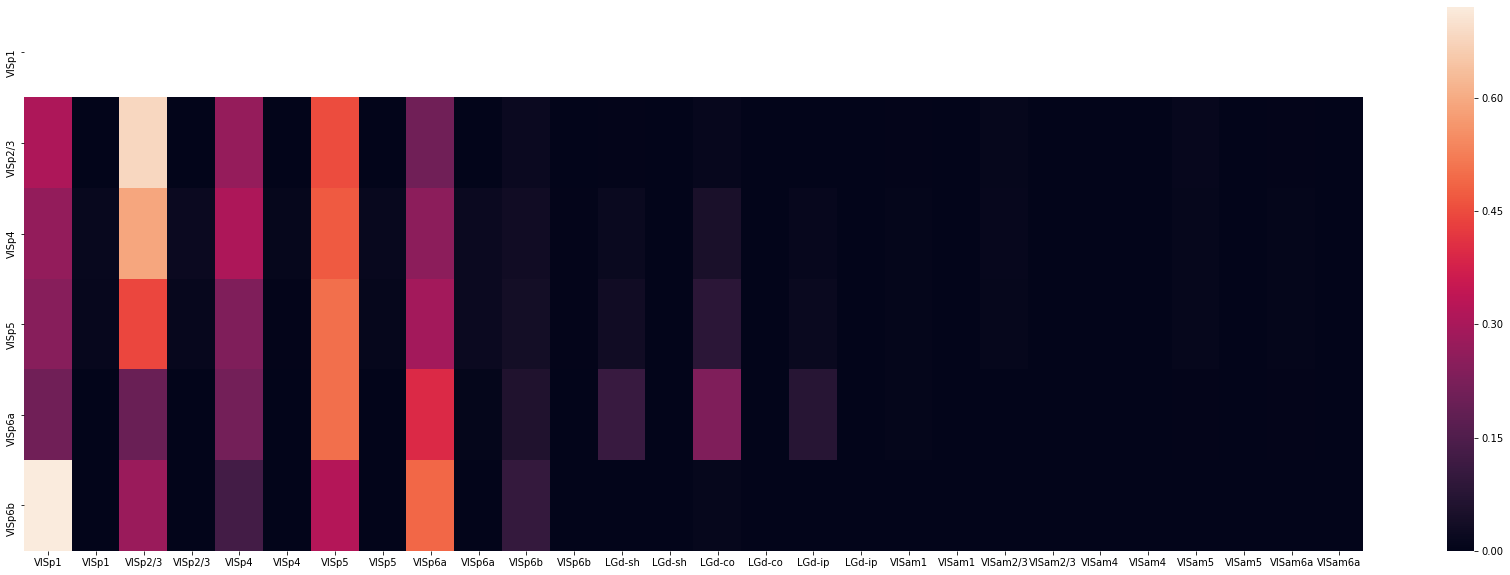

In [282]:
srs = np.asarray(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'])
trs = np.asarray(['VISp1', 'VISp2/3' ,'VISp4', 'VISp5' ,'VISp6a','VISp6b','LGd-sh', 'LGd-co', 'LGd-ip','VISam1','VISam2/3','VISam4','VISam5', 'VISam6a'])

fig, axes = plt.subplots(figsize = (30,10))
sns.heatmap(connectivity_matrices_leafall.loc[srs].loc[:,trs])

In [270]:
#get_region_predicitons
i = 0
#sid = 315
structure_data = connectivity_data.structure_datas[sid]
structures_surface_sid =structures_surface[sid]
structures_smooth_sid= structures_smooth[sid]
model_region_surface = model_ordering_surfaces[i,1]#model_ordering_surfaces[i,1]
model_region_leaf = model_ordering_leafs[i,1]#model_region_leafs[i,1]
prediction_region= source_ordering[i]
cre = eval_cres[c]
gamma = surfaces[sid].bestgamma
surface = surfaces[sid]
cre_model = True

In [271]:
cres

['C57BL/6J']

In [274]:
    model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
    model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
    nexp_surface = len(model_experiments_surface)
    
    cres_surface = structure_data.crelines[model_experiments_surface]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments_leaf]
        projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
        centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
        means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
        #supposed to check if theres a cre in that region
        #if np.isin(model_region_surface, list(means.keys())):
        if centroids.shape[0]>0:
            if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           

In [273]:
centroids.shape

(0, 3)

In [269]:
output

array([3.64671834e-03, 1.75563873e-05, 0.00000000e+00, ...,
       5.69222092e-09, 5.36088646e-06, 0.00000000e+00])

In [262]:
ia_map[structures_smooth_sid[0]]# == model_region_leaf

'RSPv2/3'

In [265]:
ia_map[model_region_leaf]

'VISp1'

In [264]:
structures_smooth_sid.shape

(1128,)

In [257]:
np.where(structures_smooth_sid == model_region_leaf)[0]

array([], dtype=int64)

In [255]:
model_experiments_leaf

array([], dtype=int64)

In [67]:
gd_nw_leaf_creleaf2 = {}
for m in range(12):
    sid = major_structure_ids[m]
    gd_nw_leaf_creleaf2[sid] = gsnwl[m]

In [66]:
gsnwl = np.asarray([.01,.001,.01,.1,.1,1.,0.1,0.001,1.,0.1,0.1,0.01])

In [70]:
connectivity_matrices_leafall = get_connectivity_matrices2_nw(connectivity_data,
                                                      gamma_dict = gd_nw_leaf_creleaf2,
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering = np.asarray([[315,315,315,315,315,315],[593, 821, 721, 778, 33, 305]], dtype = int).transpose(),
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves[117:123],
                                                  target_ordering= ontological_order_leaves,
                                                     cre_model = False)
connectivity_matrices_leafall = pd.DataFrame(connectivity_matrices_leafall[0], columns = cnames, index=np.asarray(['VISp1','VISp2/3','VISp4','VISp5','VISp6a','VISp6b']))

0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


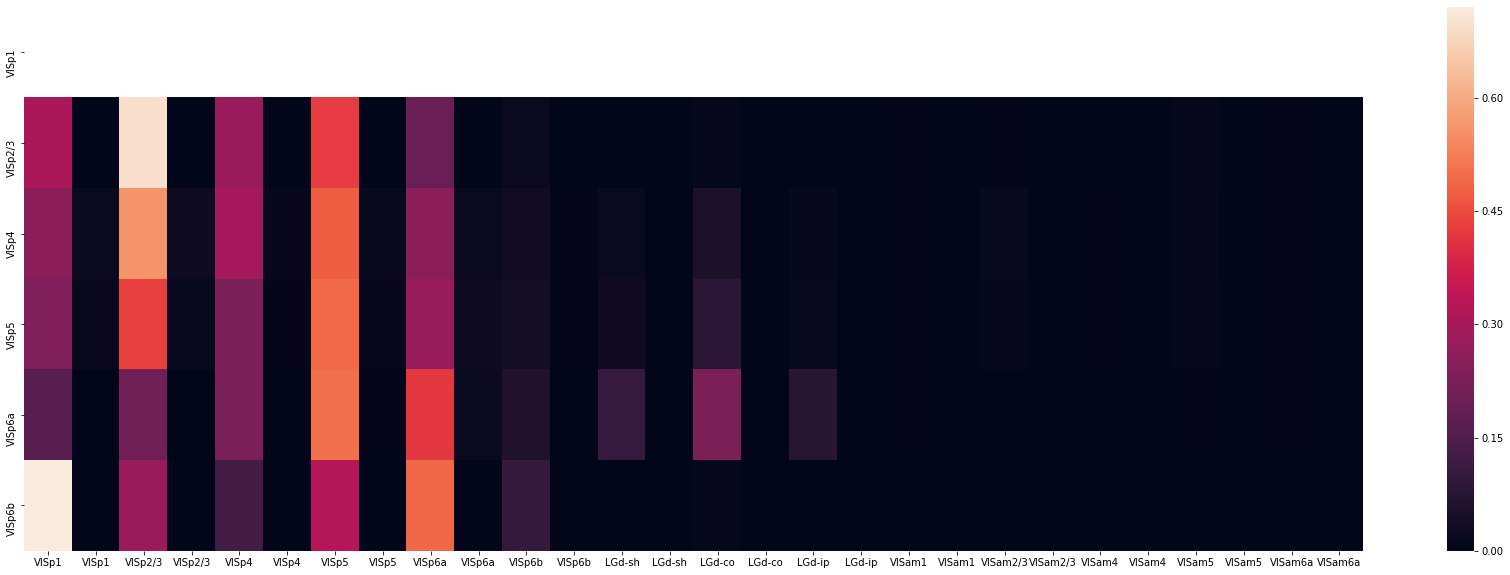

In [71]:
srs = np.asarray(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'])
trs = np.asarray(['VISp1', 'VISp2/3' ,'VISp4', 'VISp5' ,'VISp6a','VISp6b','LGd-sh', 'LGd-co', 'LGd-ip','VISam1','VISam2/3','VISam4','VISam5', 'VISam6a'])

fig, axes = plt.subplots(figsize = (30,10))
sns.heatmap(connectivity_matrices_leafall.loc[srs].loc[:,trs])

In [ ]:
connectivity_matrices_leafall = get_connectivity_matrices2_nw(connectivity_data,
                                                      gamma_dict = gd_nw_leaf_creleaf2,
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering = np.asarray([[315,315,315,315,315,315],[593, 821, 721, 778, 33, 305]], dtype = int).transpose(),
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves[117:123],
                                                  target_ordering= ontological_order_leaves,
                                                     cre_model = False)
connectivity_matrices_leafall = pd.DataFrame(connectivity_matrices_leafall[0], columns = cnames, index=np.asarray(['VISp1','VISp2/3','VISp4','VISp5','VISp6a','VISp6b']))

In [31]:
gs = gammas[[6,
        0,
        6,
        4,
        6,
        4,
        4,
        6,
        4,
        4,
        6,
        4]]

In [30]:
gammas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])

In [32]:
surfaces_str = {}
#surfaces_leaf = {}
for m in range(12):
    sid = major_structure_ids[m]
    surfaces_str[sid] = connectivity_data.structure_datas[sid].loss_surface_cv_str
    surfaces_str[sid].bestgamma =  gs[m]#gammas[twostage_str_creleaf2.bestgamma[m]]

0 68.0


NameError: name 'model_ordering' is not defined

In [ ]:
connectivity_data.structure_datas[sid].centroids.shape

In [ ]:
connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv.shape

In [ ]:
connectivity_data.structure_datas[sid].smoothed_losses_str.shape

0


NameError: name 'get_embedding_cv' is not defined

In [12]:
class Crossval:
    
    def __init__(self):
        2+2

In [13]:
twostage_str_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    


AttributeError: 'StructureData' object has no attribute 'smoothed_losses_str'

In [9]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [10]:
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_str_creleaf2.loocvpredictions = loocvpredictions
twostage_str_creleaf2.losses = get_loss(reg_proj_norm, twostage_str_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_str_creleaf2.bestgamma  = get_best_hyperparameters(twostage_str_creleaf2.losses,keys)
twostage_str_creleaf2.meanloss = get_loss_best_hyp(twostage_str_creleaf2.losses, twostage_str_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

NameError: name 'gammas' is not defined

In [21]:
twostage_str_creleaf2.meanloss

array([0.02480253, 0.60140432, 0.09111914, 0.20309182, 0.16384254,
       0.14736513, 0.11575248, 0.04578022, 0.23520951, 0.1241904 ,
       0.04673123, 0.26290721])

In [61]:

# from mcmodels.core import Mask

# def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures, model_ordering_leaf, model_region_surface, source_ordering, target_ordering, eval_cres):
    
#     nsource = len(source_ordering)
#     #n#target = len(target_ordering)
#     ncre = len(eval_cres)

#     ipsi_target_regions = connectivity_data.ipsi_target_regions
#     contra_target_regions = connectivity_data.contra_target_regions                               
#     ipsi_indices= np.asarray([])
#     contra_indices = np.asarray([])
#     for iy in target_ordering: 
#         ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#         contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
#     ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
#     contra_indices = np.asarray(contra_indices, dtype = int)    
#     reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
#     ntarget = len(reorder)
      
#     connectivity = np.zeros((ncre, nsource, ntarget))
#     connectivity[:] = np.nan
#     #structure_major_dictionary = connectivity_data.structure_major_dictionary
#     for c in range(ncre):
#         for i in range(nsource):
#             print(i,source_ordering[i])
#             sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
#             gamma = gamma_dict[sid]
#             connectivity[c,i] = get_region_prediction3(cache,
#                                                       connectivity_data.structure_datas[sid],
#                                                       exp_structures = structures[sid],
#                                                       model_region_leaf = model_ordering_leaf[i,1],
#                                                        model_region_surface = model_region_surface[i,1],
#                                                       prediction_region= source_ordering[i],
#                                                       cre = eval_cres[c],
#                                                       gamma = surfaces[sid].bestgamma,
#                                                       surface = surfaces[sid],
#                                                       cre_model = True)
                                                      
#     connectivity = connectivity[:,:,reorder]                                                  
                                                      
#     return(connectivity)

# def get_region_prediction3(cache, structure_data,  exp_structures, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    
#     #model_experiments = np.where(exp_structures == model_region)[0]
#     model_experiments_leaf = np.where(exp_structures == model_region_leaf)[0]
#     nexp = len(model_experiments_leaf)
    
#     cres = structure_data.crelines[model_experiments_leaf]
#     mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

# #     if surface != None and cre_model != True:
# #         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
# #         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
# #         predictions = get_nw_predictions(projections, losses, gamma)
# #         output = np.mean(predictions, axis = 0)
        
#     if surface != None and cre_model == True:
#         projections = structure_data.reg_proj_norm[model_experiments_leaf]
#         centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
#         means = get_means(projections, cres, np.repeat(model_region_surface,nexp))
#         #print(means)
#         print(prediction_region)
#         #print(prediction_region, model_region,means.keys())
#         #supposed to check if theres a cre in that region
#         if np.isin(model_region_surface, list(means.keys())):
#             if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
#                 losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region_surface])
#                 predictions = get_nw_predictions(projections, losses, gamma)
#                 output = np.mean(predictions, axis = 0)
#             else:
#                 output = np.zeros(projections.shape[1])
#                 output[:] = np.nan
#         else:
#             output = np.zeros(projections.shape[1])
#             output[:] = np.nan           
# #     if surface == None and cre_model != True:
# #         means = get_means(projections, cres, [model_region])
# #         predictions = means[cres]
# #         output = np.mean(predictions, axis = 0)
        
#     if surface == None and cre_model == True:
        
        
#         modelcre_experiments = np.where(cres == cre)[0]
#         if len(modelcre_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
#             centroids = structure_data.centroids[model_experiments][modelcre_experiments]
#             #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
            
#     if surface == None and cre_model == False:
        
#         if len(model_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments]
#             centroids = structure_data.centroids[model_experiments]
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
        
#     return(output)


In [28]:
surfaces_str = {}
#surfaces_leaf = {}
for m in range(12):
    sid = major_structure_ids[m]
    surfaces_str[sid] = connectivity_data.structure_datas[sid].loss_surface_cv_str
    surfaces_str[sid].bestgamma =  gammas[twostage_str_creleaf2.bestgamma[m]]

In [40]:
def get_aligned_ids(list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(ontological_order_leaves)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)
eval_cres = ['C57BL/6J']
ontological_order_leaves_majors = get_aligned_ids(ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(ontological_order_leaves,ontological_order)



In [102]:
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_summaries = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()

In [42]:
gamma_dict = {}
for i in range(12):
    gamma_dict[major_structure_ids[i]] = gammas[twostage_str_creleaf2.bestgamma[i,0]]
    

In [57]:
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [69]:
connectivity_matrices = get_connectivity_matrices3(connectivity_data, 
                                                   surfaces = surfaces_str,
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering_leaf = model_ordering_leaf,
                                                   model_region_surface = model_ordering_summary,
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves,
                                                  target_ordering= ontological_order_leaves)

0 68.0
68.0
1 667.0
667.0
2 526157192.0
526157192.0
3 526157196.0
526157196.0
4 526322264.0
526322264.0
5 320.0
320.0
6 943.0
943.0
7 648.0
648.0
8 844.0
844.0
9 882.0
882.0
10 656.0
656.0
11 962.0
962.0
12 767.0
767.0
13 1021.0
1021.0
14 1085.0
1085.0
15 558.0
558.0
16 838.0
838.0
17 654.0
654.0
18 702.0
702.0
19 889.0
889.0
20 929.0
929.0
21 981.0
981.0
22 201.0
201.0
23 1047.0
1047.0
24 1070.0
1070.0
25 1038.0
1038.0
26 1062.0
1062.0
27 1030.0
1030.0
28 113.0
113.0
29 1094.0
1094.0
30 1128.0
1128.0
31 478.0
478.0
32 510.0
510.0
33 878.0
878.0
34 657.0
657.0
35 950.0
950.0
36 974.0
974.0
37 1102.0
1102.0
38 2.0
2.0
39 450.0
450.0
40 854.0
854.0
41 577.0
577.0
42 625.0
625.0
43 945.0
945.0
44 1026.0
1026.0
45 1006.0
1006.0
46 670.0
670.0
47 1086.0
1086.0
48 1111.0
1111.0
49 9.0
9.0
50 461.0
461.0
51 182305693.0
182305693.0
52 182305697.0
182305697.0
53 182305701.0
182305701.0
54 182305705.0
182305705.0
55 182305709.0
182305709.0
56 182305713.0
182305713.0
57 873.0
873.0
58 806.0
806.0

101.0
480 711.0
711.0
481 1039.0
1039.0
482 903.0
903.0
483 642.0
642.0
484 651.0
651.0
485 429.0
429.0
486 437.0
437.0
487 445.0
445.0
488 653.0
653.0
489 661.0
661.0
490 576.0
576.0
491 939.0
939.0
492 143.0
143.0
493 839.0
839.0
494 1048.0
1048.0
495 372.0
372.0
496 83.0
83.0
497 136.0
136.0
498 106.0
106.0
499 203.0
203.0
500 955.0
955.0
501 963.0
963.0
502 307.0
307.0
503 1098.0
1098.0
504 1107.0
1107.0
505 852.0
852.0
506 859.0
859.0
507 970.0
970.0
508 978.0
978.0
509 177.0
177.0
510 169.0
169.0
511 1069.0
1069.0
512 209.0
209.0
513 202.0
202.0
514 225.0
225.0
515 217.0
217.0
516 765.0
765.0
517 773.0
773.0
518 781.0
781.0
519 206.0
206.0
520 230.0
230.0
521 222.0
222.0
522 912.0
912.0
523 976.0
976.0
524 984.0
984.0
525 1091.0
1091.0
526 936.0
936.0
527 944.0
944.0
528 951.0
951.0
529 957.0
957.0
530 968.0
968.0
531 1007.0
1007.0
532 1056.0
1056.0
533 1064.0
1064.0
534 1025.0
1025.0
535 1033.0
1033.0
536 1041.0
1041.0
537 1049.0
1049.0
538 989.0
989.0
539 91.0
91.0
540 846.0
84

In [73]:
#connectivity_data
#surfaces = surfaces,
#cres = crelist
#structures = summary_structures
#model_ordering = np.asarray([[315,385],[315,385]])#[230:231]
#eval_cres = eval_cres,
#source_ordering = np.asarray([821,721])#[230:231],
#target_ordering= np.asarray([821,721])
target_ordering= ontological_order_leaves

In [74]:
rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions                               
ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)    
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
ntarget = len(reorder)

#cnames = np.concatenate([ipsi_colnames, contra_colnames])

In [77]:
colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])

In [78]:
wt_conn = pd.DataFrame(connectivity_matrices[0], index = rnames, columns = cnames)

In [80]:
#np.asarray(wt_conn.columns)
source_regions = np.asarray(['VISp2/3', 'VISp4', 'VISp5', 'VISp6a','VISl4', 'VISl5', 'VISl6a'])
target_regions = np.concatenate([source_regions,['LGd-sh', 'LGd-co', 'LGd-ip']])
#target_regions = np.asarray(['LGv','LGd','VISp','VISl'])

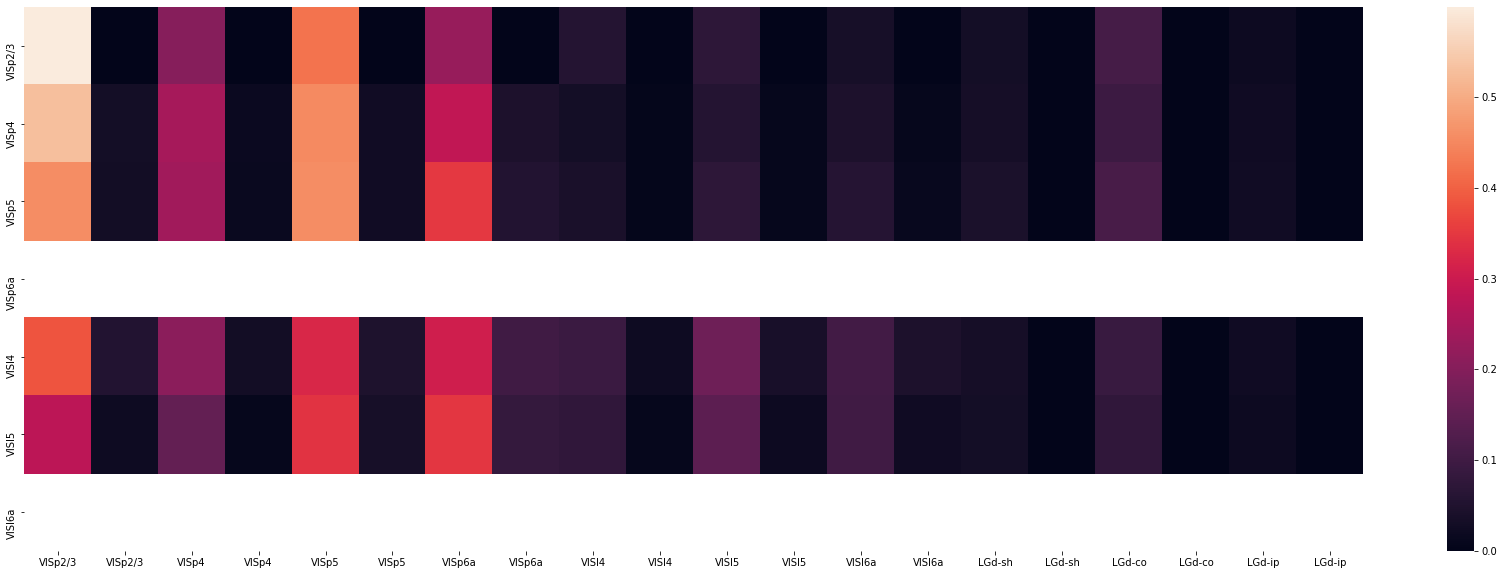

In [81]:
fig, axes = plt.subplots(figsize = (30,10))
#cbar_ax = fig.add_axes([.91, .3, .03, .4])

#tp = #np.log(wt_conn.loc[source_regions].loc[:,target_regions])
tp = wt_conn.loc[source_regions].loc[:,target_regions]
#tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp)
#sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,0], cbar = False)


In [82]:
connectivity_matrices_nwleafall = get_connectivity_matrices3(connectivity_data, 
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering_leaf = model_ordering_leaf,
                                                   model_region_surface = model_ordering_leaf,
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves,
                                                  target_ordering= ontological_order_leaves)

TypeError: get_connectivity_matrices3() missing 1 required positional argument: 'surfaces'

In [84]:
def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

In [ ]:
gd_nw_leaf_creleaf2 = gamma_dict

In [85]:
connectivity_matrices_leafall = get_connectivity_matrices2_nw(connectivity_data,
                                                      gamma_dict = gd_nw_leaf_creleaf2,
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering = np.asarray([[315,821],[315,721]]),
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves[118:120],
                                                  target_ordering= ontological_order_leaves,
                                                     cre_model = False)
connectivity_matrices_leafall = pd.DataFrame(connectivity_matrices_leafall[0], columns = cnames, index=['VISp2/3','VISp4'])

NameError: name 'gd_nw_leaf_creleaf2' is not defined

In [ ]:
srs = np.asarray(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'])
trs = np.asarray(['VISp1', 'VISp2/3' ,'VISp4', 'VISp5' ,'VISp6a','VISp6b','LGd-sh', 'LGd-co', 'LGd-ip','VISam1','VISam2/3','VISam4','VISam5', 'VISam6a'])

fig, axes = plt.subplots(figsize = (30,10))
sns.heatmap(connectivity_matrices_leafall.loc[srs].loc[:,trs])